In [232]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [231]:
# %cd /content/gdrive/My Drive/HSE_DL_2021/01_week

In [1]:
from IPython import display

__Домашнее задание.__
Нужно обучить нейронную сеть, точность классификация должна быть не меньше __60%__. Как это можно получить:
1. Посмотрите на данные, характеристики.
2. Попробуйте менять гиперпараметры сети.
3. Обратите внимание на саму архитектуру сети.
4. Сделайте подсчет точности на валидационной выборке, не использую `torchmetrics`.

### NB! Концепция реализации 

То, что вы увидете ниже, представляет из себя компиляцию кода из первого и второго (в основном) семинарского занятия, которая была допилена. 

Я пробовал менять многие параметры моделей, как в части гиперпараметров, так и архитектуры (единственное, не побаловался с разными shaduler'ами).
Ниже реализация далеко не с лучшим результатом, но память у меня плохая, не смог вспомнить лучшие параметры 
(в лучшем случае accuracy на валидационной выборке почти достигало 0.7).

Основные доработки кода по сравнению с исходной тетрадью:

1. Проведено масштабирование признаков
2. Внесены технические правки в функцию run_train, без которых код отказывался запускаться локально
3. Внутри нейросетки заменена сигмоида на ReLU
4. Между двумя ReLU добавлен слой Dropout (кажется, не очень полезная штука в нашем случае).
5. HIDDEN SIZE сделал больше, чем INPUT SIZE (кажется это оказалось даже вредно, но было лень пересчитывать).

### 0. Загрузка данных и предварительная обработка

In [80]:
# display.Image('images/Pipeline.png')

In [2]:
# Подгрузим немного пакетов :) 
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.model_selection import train_test_split

%matplotlib inline

In [3]:
X = pd.read_csv('./data/X_cat.csv', sep = '\t', index_col=0)
target = pd.read_csv('./data/y_cat.csv', sep = '\t', index_col=0, names=['status'])

print(X.shape)
X.head()

(26729, 37)


,IsDog,Age,HasName,NameLength,NameFreq,MixColor,ColorFreqAsIs,ColorFreqBase,TabbyColor,MixBreed,...,SexStatus_Flawed,SexStatus_Intact,SexStatus_Unknown,Weekday_0,Weekday_1,Weekday_2,Weekday_3,Weekday_4,Weekday_5,Weekday_6
0,1,365.0,1,7,0.000157,1,0.032919,0.463624,0,1,...,1,0,0,0,0,1,0,0,0,0
1,0,365.0,1,5,0.000655,0,0.008092,0.015005,1,1,...,1,0,0,0,0,0,0,0,0,1
2,1,730.0,1,6,0.000052,1,0.026293,0.357521,0,1,...,1,0,0,0,0,0,0,0,1,0
3,0,21.0,0,7,0.285871,0,0.000471,0.058418,0,1,...,0,1,0,0,0,0,0,1,0,0
4,1,730.0,0,7,0.285871,0,0.023831,0.075353,0,0,...,1,0,0,0,0,0,0,1,0,0


In [4]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: status, dtype: int64

Видим, что классы несбалансированы. Попробуем оставит четыре класса и объединить класс умерших животных с классом животных, которых усыпили. 

In [210]:
target = target.iloc[:, :]
target[target == 'Died'] = 'Euthanasia'

Закодируем классы.

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(target)
y

C:\Users\maxle\anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


array([3, 2, 0, ..., 0, 4, 4])

### 1. Масштабирование

In [212]:
X_train, X_test, y_train, y_test = train_test_split(X.iloc[:, :].values, y,
                                                    test_size=0.2, stratify=y, random_state=42)

In [213]:
pd.Series(y).value_counts()

0    10769
3     9422
2     4786
1     1752
dtype: int64

In [6]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

NameError: name 'X_train' is not defined

### 2. Собираем свою нейросеть

__Импорт библиотек__

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [81]:
# !pip install torchmetrics

In [2]:
# Подгружаем pytorch 
import torch

print(torch.__version__)

1.6.0+cpu


In [3]:
import torch.nn as nn # содержит функции для реалзации архитектуры нейронных сетей
import torch.nn.functional as F # содержит различные функции активации и не только
import torch.optim as optim
import torch.utils.data as data_utils

from torchmetrics import Accuracy

__Функция для отрисовки графиков__ лоссов разных моделей сеток

In [216]:
def plot(histories):
    plt.figure(figsize=(16,10))
    
    for name, val_loss in histories:
        plt.plot(val_loss, label=name)

    plt.legend()

__DataLoader__ для обучения сети

Для того чтобы подавать данные в нейронную сеть, создадим `DataLoader`, который предоставляет гибкий API для работы с входными данными.

In [217]:
def create_data_loader(X_train, y_train, X_test, y_test):
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor,
                                         batch_size=BATCH_SIZE,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=BATCH_SIZE,
                                        shuffle=False)
    return train_loader, test_loader

__Архитектура модели__

Архитектуру нейронной сети в PyTorch можно описать нескольками способами, в дальнейшем мы рассмотрим их более подробно. Сейчас предлагается сделать это используя `Sequential`.
`Sequential` -- это последовательный способ объявления каждой компоненты архитектуры нейронной сети.

In [218]:
INPUT_SIZE = 37
HIDDEN_SIZE = 42
OUTPUT_SIZE = 4
BATCH_SIZE = 100
EPOCHS = 105
LEARNING_RATE = 0.001

def build_model():
    model = nn.Sequential(  
        # Добавляем в нашу модель первый слой из 25 нейронов
        nn.Linear(in_features=INPUT_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(), # # заменяем сигмоиду на ReLU
        
        nn.Dropout(), # слой показал себя плохо: модели перестают обучаться
        # Добавляем ещё один слой из 25 нейронов
        nn.Linear(in_features=HIDDEN_SIZE, out_features=HIDDEN_SIZE),
        nn.ReLU(), # заменяем сигмоиду на ReLU
        
        # Выходной вектор на количество классов, получаем с помощью такого же линейного приеобразования,
        # как и предыдущие слои, но уже на нужное количество выходных нейронов (т.е. классов)
        nn.Linear(in_features=HIDDEN_SIZE, out_features=OUTPUT_SIZE),
        nn.Softmax() 
    )

    return model

Функция `Linear` представляет собой полносвязный слой, где присутствуют обучаемая матрица и обучаемый баес.

In [220]:
train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

In [82]:
# display.Image('images/FClayer.png')

In [221]:
model = build_model()

In [222]:
print(model)

Sequential(
  (0): Linear(in_features=37, out_features=42, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=42, out_features=42, bias=True)
  (4): ReLU()
  (5): Linear(in_features=42, out_features=4, bias=True)
  (6): Softmax(dim=None)
)


In [88]:
# display.Image('images/MLP2.jpg')

In [86]:
# display.Image('images/Softmax.png')

__Обучение модели__

In [223]:
criterion = nn.CrossEntropyLoss()
accuracy = Accuracy()
# optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

Перед тем как обучать нашу нейросеть, нужно задать параметры обучения. 
- Во-первых, метод оптимизации. 
- Во-вторых, функцию потерь. 
- В-третьих, парочку метрик, на которые нам хотелось бы смотреть в процессе обучения.  

Создадим массивы, куда будем складывать значение целевой функции на обучающей и валиационной выборках, а также точность.

Ниже представлен код __обучения__ сети. Нужно обратить внимание на несколько моментов:
1. Обучение ведется в течение нескольких эпох -- что значит несколько проходов по выборке.
2. `train_loader` позволяет итеративно проходится по выборке и на каждой итерации получать батч заранее заданного размера.
3. На каждом шаге обнуляем градиенты `optimizer.zero_grad()`, чтобы не накапливать их, тем самым неккоректно обновлять веса.
4. Вызывать явно `loss.backward()` для вычисления градиентов.
5. Вызывать явно `optimizer.step()` для обновления весов.

In [224]:
def run_train(model, optimizer, criterion, scheduler=None):
    train_loss_values = []
    train_accuracy_values = []
    valid_loss_values = []
    valid_accuracy = []
    lr_history = []

    model.train()
    for epoch in range(EPOCHS):
        running_loss = []
        running_acc = []
        for features, label in train_loader:
            # Reset gradients
            optimizer.zero_grad()
            
            # run model on the chosen batch
            output = model(features)

            # Calculate error and backpropagate
            loss = criterion(output, label.long())
            loss.backward()

            # manual accuracy calculation; no torch lightning
            acc = np.true_divide((output.argmax(dim=1)==label).sum(), len(label))

            # Update weights with gradients
            optimizer.step()

            running_loss.append(loss.item())
            running_acc.append(acc)

        train_loss_values.append(np.mean(running_loss))
        train_accuracy_values.append(np.mean(running_acc))
        if epoch % 20 == 0:
            print('EPOCH %d,  train_loss: %f, train_accuracy: %f' % (epoch, train_loss_values[-1], train_accuracy_values[-1]))


        model.eval()
        # Run validation
        running_loss = []
        running_acc = []
        with torch.no_grad(): # in validation loop we do not need gradients calculation; so switch it off
            for features, label in test_loader:
                output = model(features)
                
                # Calculate error an accuracy
                loss = criterion(output, label.long())
                acc = np.true_divide((output.argmax(dim=1)==label).sum(), len(label))

                running_loss.append(loss.item())
                running_acc.append(acc)

            valid_loss_values.append(np.mean(running_loss))
            valid_accuracy.append(np.mean(running_acc))
            if epoch % 20 == 0:
                print('EPOCH %d, valid_loss: %f, valid_accuracy: %f' % (epoch, valid_loss_values[-1], valid_accuracy[-1]))

        if scheduler is not None:
            # Decay Learning Rate
            scheduler.step()
            lr_history.append(scheduler.get_last_lr())

    if scheduler is not None:
        return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy, lr_history
        
    return train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy

# Оптимизация

### SGD 

In [227]:
# Первая простенькая моделька 
model1 = build_model()

# инициализируем SGD optimizer
sgd = optim.SGD(model1.parameters(), lr=LEARNING_RATE)

# инициализируем Loss function (функцию потерь)
criterion = nn.CrossEntropyLoss()

# запускаем процесс обучения
train_loss_values, train_accuracy_values, valid_loss_values, valid_accuracy = run_train(model1, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.386664, train_accuracy: 0.256539
EPOCH 0, valid_loss: 1.385570, valid_accuracy: 0.262890
EPOCH 20,  train_loss: 1.349825, train_accuracy: 0.516757
EPOCH 20, valid_loss: 1.349030, valid_accuracy: 0.506884
EPOCH 40,  train_loss: 1.301285, train_accuracy: 0.543657
EPOCH 40, valid_loss: 1.301277, valid_accuracy: 0.531079
EPOCH 60,  train_loss: 1.241149, train_accuracy: 0.566309
EPOCH 60, valid_loss: 1.243177, valid_accuracy: 0.555741
EPOCH 80,  train_loss: 1.195382, train_accuracy: 0.588310
EPOCH 80, valid_loss: 1.198711, valid_accuracy: 0.584968
EPOCH 100,  train_loss: 1.165644, train_accuracy: 0.602468
EPOCH 100, valid_loss: 1.169899, valid_accuracy: 0.593148


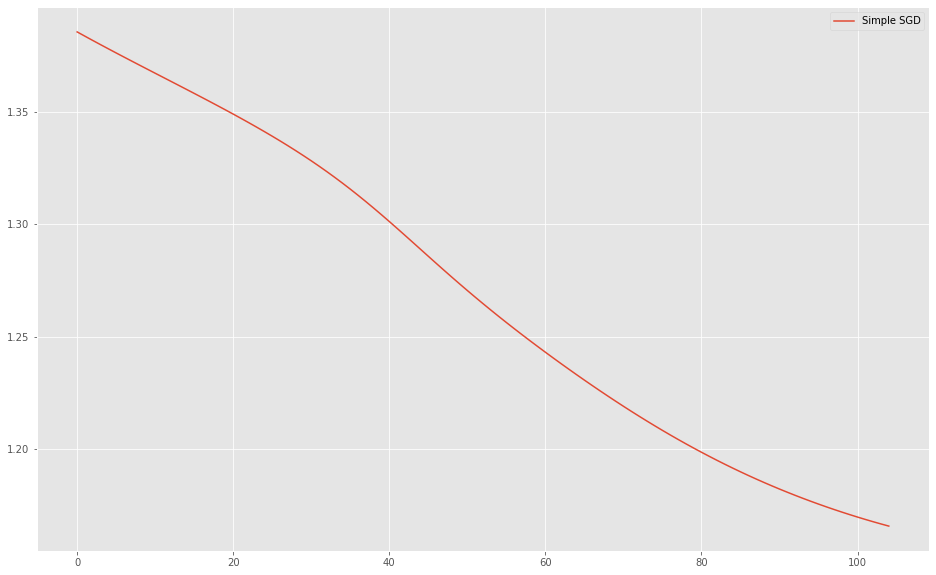

In [228]:
plot([('Simple SGD', valid_loss_values)])

### Nesterov Momentum

In [229]:
# Первая простенькая моделька 
model2 = build_model()

# инициализируем SGD optimizer
sgd = optim.SGD(model2.parameters(), lr=LEARNING_RATE, momentum=0.9, nesterov=True)

# запускаем процесс обучения
train_loss_values2, train_accuracy_values2, valid_loss_values2, valid_accuracy2 = run_train(model2, optimizer=sgd, criterion=criterion)

EPOCH 0,  train_loss: 1.383971, train_accuracy: 0.248211
EPOCH 0, valid_loss: 1.370196, valid_accuracy: 0.403639
EPOCH 20,  train_loss: 1.126282, train_accuracy: 0.610609
EPOCH 20, valid_loss: 1.131589, valid_accuracy: 0.603148
EPOCH 40,  train_loss: 1.110105, train_accuracy: 0.627077
EPOCH 40, valid_loss: 1.114739, valid_accuracy: 0.624082
EPOCH 60,  train_loss: 1.093434, train_accuracy: 0.644386
EPOCH 60, valid_loss: 1.098184, valid_accuracy: 0.637939
EPOCH 80,  train_loss: 1.089145, train_accuracy: 0.648657
EPOCH 80, valid_loss: 1.095205, valid_accuracy: 0.642568
EPOCH 100,  train_loss: 1.086720, train_accuracy: 0.651404
EPOCH 100, valid_loss: 1.093976, valid_accuracy: 0.645161


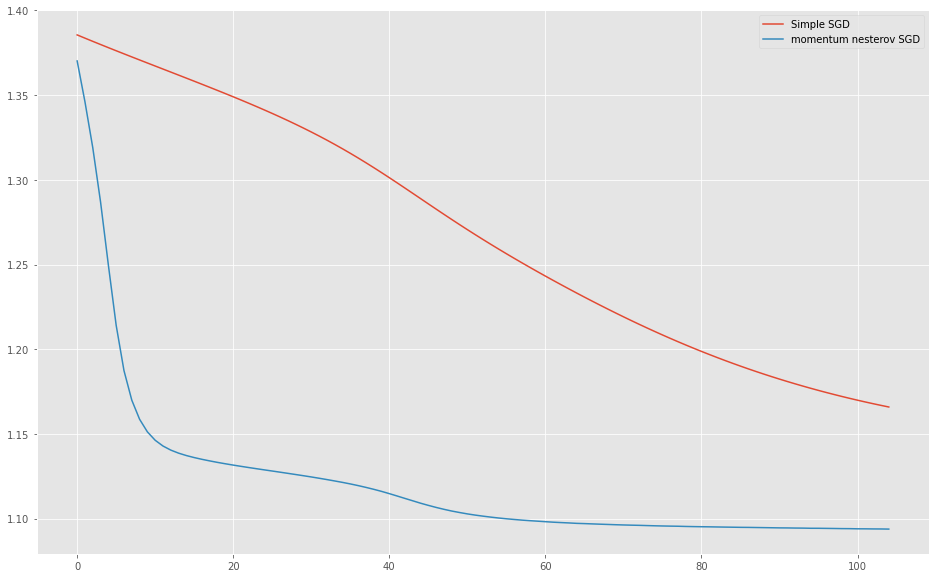

In [233]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2)])

### RMSprop 

In [234]:
# Первая простенькая моделька 
model3 = build_model()

# инициализируем SGD optimizer
rmsprop = optim.RMSprop(model3.parameters(), lr=LEARNING_RATE, alpha=0.9, eps=1e-08)

# запускаем процесс обучения
train_loss_values3, train_accuracy_values3, valid_loss_values3, valid_accuracy3 = run_train(model3, optimizer=rmsprop, criterion=criterion)

EPOCH 0,  train_loss: 1.189258, train_accuracy: 0.570834
EPOCH 0, valid_loss: 1.121967, valid_accuracy: 0.605032
EPOCH 20,  train_loss: 1.062494, train_accuracy: 0.677779
EPOCH 20, valid_loss: 1.086032, valid_accuracy: 0.651739
EPOCH 40,  train_loss: 1.049760, train_accuracy: 0.694292
EPOCH 40, valid_loss: 1.088617, valid_accuracy: 0.648003
EPOCH 60,  train_loss: 1.040263, train_accuracy: 0.703947
EPOCH 60, valid_loss: 1.090564, valid_accuracy: 0.647697
EPOCH 80,  train_loss: 1.034640, train_accuracy: 0.709712
EPOCH 80, valid_loss: 1.092891, valid_accuracy: 0.646369
EPOCH 100,  train_loss: 1.029446, train_accuracy: 0.714967
EPOCH 100, valid_loss: 1.096849, valid_accuracy: 0.642448


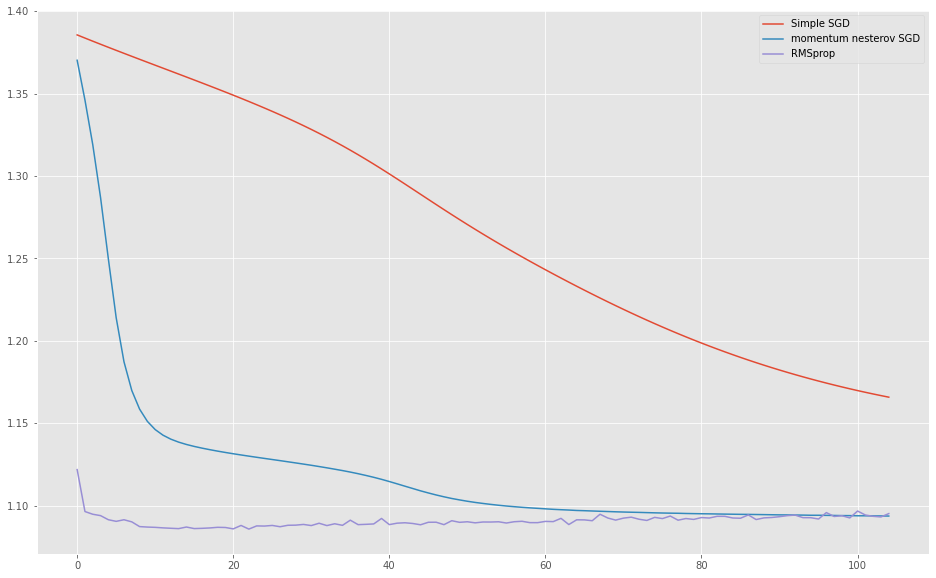

In [235]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3)])

# Адам

In [236]:
# Первая простенькая моделька 
model4 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model4.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999), eps=1e-08)

# запускаем процесс обучения
train_loss_values4, train_accuracy_values4, valid_loss_values4, valid_accuracy4 = run_train(model4, optimizer=adam, criterion=criterion)

EPOCH 0,  train_loss: 1.195200, train_accuracy: 0.566266
EPOCH 0, valid_loss: 1.123559, valid_accuracy: 0.602963
EPOCH 20,  train_loss: 1.062015, train_accuracy: 0.678715
EPOCH 20, valid_loss: 1.086455, valid_accuracy: 0.649702
EPOCH 40,  train_loss: 1.049956, train_accuracy: 0.693751
EPOCH 40, valid_loss: 1.090051, valid_accuracy: 0.646369
EPOCH 60,  train_loss: 1.041001, train_accuracy: 0.703041
EPOCH 60, valid_loss: 1.091796, valid_accuracy: 0.646957
EPOCH 80,  train_loss: 1.034117, train_accuracy: 0.710490
EPOCH 80, valid_loss: 1.093781, valid_accuracy: 0.644364
EPOCH 100,  train_loss: 1.028991, train_accuracy: 0.716218
EPOCH 100, valid_loss: 1.096124, valid_accuracy: 0.643221


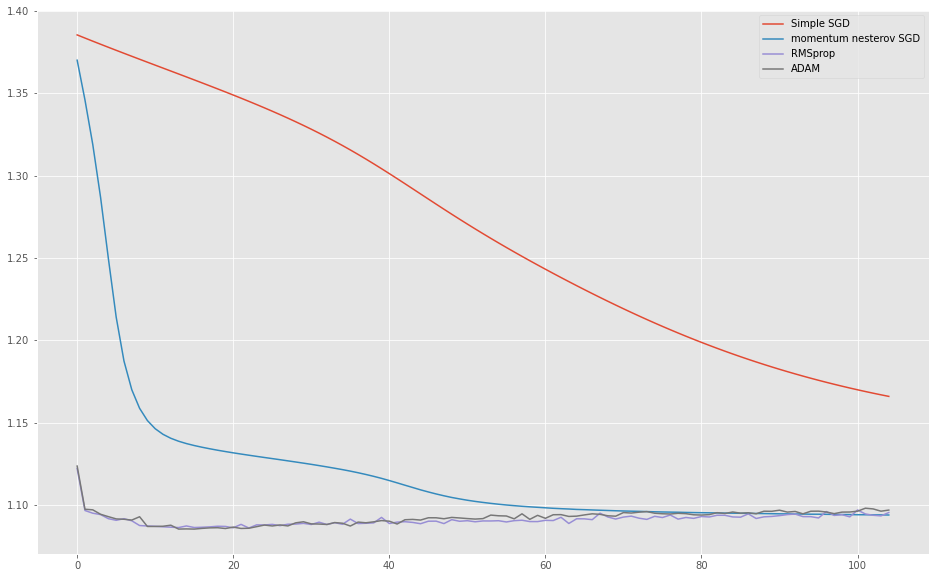

In [237]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4)])

# Adam + sheduler (step LR)

In [238]:
# функция для картинок, чтобы видеть как скорость обученя меняется от эпохи к эпохе
def plot_learning_rate(lr_history):
    fig = plt.figure()
    plt.plot(range(1, EPOCHS+1), lr_history, label='learning rate')
    plt.xlabel("epoch")
    plt.xlim([1, EPOCHS+1])
    plt.ylabel("learning rate")
    plt.legend(loc=0)
    plt.grid(True)
    plt.title("Learning rate")
    plt.show()

In [239]:
INIT_LR = 0.1  # берём lr намеренно большим

In [240]:
from torch.optim.lr_scheduler import StepLR


# Первая простенькая моделька 
model5 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model5.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-08)

# инициализируем 
scheduler = StepLR(adam, step_size=50, gamma=0.5)

# запускаем процесс обучения
train_loss_values5, train_accuracy_values5, valid_loss_values5, valid_accuracy5, lr_history5 = run_train(model5, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.246794, train_accuracy: 0.495561
EPOCH 0, valid_loss: 1.193201, valid_accuracy: 0.550459
EPOCH 20,  train_loss: 1.391165, train_accuracy: 0.352503
EPOCH 20, valid_loss: 1.392202, valid_accuracy: 0.351465
EPOCH 40,  train_loss: 1.391146, train_accuracy: 0.352522
EPOCH 40, valid_loss: 1.392202, valid_accuracy: 0.351465
EPOCH 60,  train_loss: 1.391156, train_accuracy: 0.352512
EPOCH 60, valid_loss: 1.392202, valid_accuracy: 0.351465
EPOCH 80,  train_loss: 1.391194, train_accuracy: 0.352474
EPOCH 80, valid_loss: 1.392202, valid_accuracy: 0.351465
EPOCH 100,  train_loss: 1.391184, train_accuracy: 0.352483
EPOCH 100, valid_loss: 1.392202, valid_accuracy: 0.351465


In [241]:
adam = optim.SGD(model5.parameters(), lr=INIT_LR)
scheduler = StepLR(adam, step_size=2, gamma=0.1)

# for i in range(10):
#     print(i+1, scheduler.get_last_lr())
#     scheduler.step()

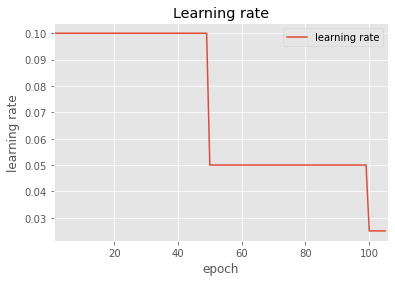

In [242]:
plot_learning_rate(lr_history5)

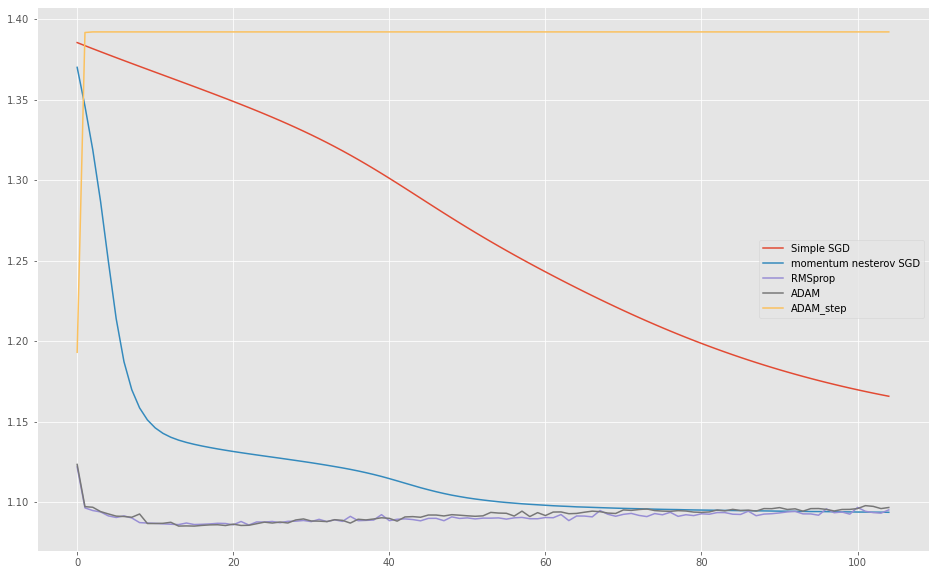

In [243]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_step', valid_loss_values5)])

# Adam MultiStepLR

In [244]:
from torch.optim.lr_scheduler import MultiStepLR


# Первая простенькая моделька 
model6 = build_model()

# инициализируем SGD optimizer
adam = optim.Adam(model6.parameters(), lr=INIT_LR, betas=(0.9, 0.999), eps=1e-02)

# инициализируем 
scheduler = MultiStepLR(adam, milestones=[10,80], gamma=0.3)

# запускаем процесс обучения
train_loss_values6, train_accuracy_values6, valid_loss_values6, valid_accuracy6, lr_history6 = run_train(model6, optimizer=adam, 
                                                                                                        criterion=criterion, scheduler=scheduler)

EPOCH 0,  train_loss: 1.141916, train_accuracy: 0.601599
EPOCH 0, valid_loss: 1.142461, valid_accuracy: 0.601111
EPOCH 20,  train_loss: 1.134646, train_accuracy: 0.609022
EPOCH 20, valid_loss: 1.141260, valid_accuracy: 0.602407
EPOCH 40,  train_loss: 1.134656, train_accuracy: 0.609012
EPOCH 40, valid_loss: 1.141260, valid_accuracy: 0.602407
EPOCH 60,  train_loss: 1.134723, train_accuracy: 0.608945
EPOCH 60, valid_loss: 1.141260, valid_accuracy: 0.602407
EPOCH 80,  train_loss: 1.134665, train_accuracy: 0.609002
EPOCH 80, valid_loss: 1.141260, valid_accuracy: 0.602407
EPOCH 100,  train_loss: 1.134704, train_accuracy: 0.608964
EPOCH 100, valid_loss: 1.141260, valid_accuracy: 0.602407


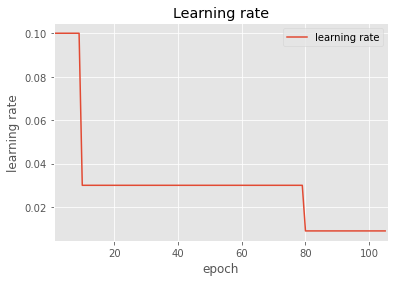

In [245]:
plot_learning_rate(lr_history6)

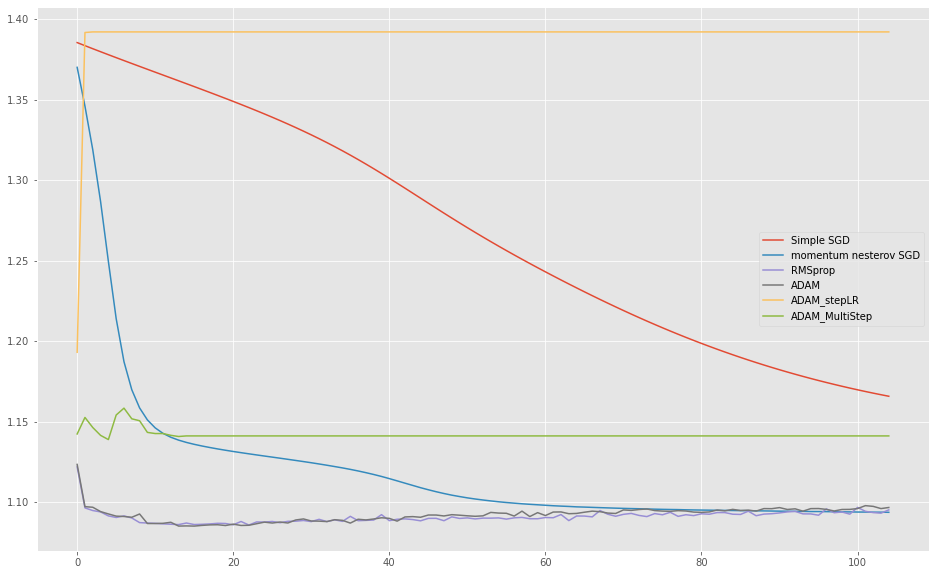

In [246]:
plot([('Simple SGD', valid_loss_values), 
      ('momentum nesterov SGD', valid_loss_values2),
      ('RMSprop', valid_loss_values3),
      ('ADAM', valid_loss_values4),
      ('ADAM_stepLR', valid_loss_values5),
      ('ADAM_MultiStep', valid_loss_values6)])

Я пробовал менять самые разные параметры, и это не лучший из полученных результатов (забыл, какие параметры были в лучше, помню максимум давал простой ADAM с valid_accuracy чуть более 70). Как правило, лучшие результаты дают RMSprop  и Adam (простой и multistep). В текущей реализации Multistep оказался менее эффективным и как-то совершенно странно повёл себя Adam со StepLR. 

### __Сохранение лучшей модели__

Сохраню модель Adam и реализацию в дальнейшем подсчет accuracy на валидационной выборке вручную. 

In [251]:
torch.save(model4, 'simple_nn.pth')

Теперь загрузим сохраненную модель и посмотрим на ее предсказания. Важно! Когда идет этап inference модели, то нужно явно вызвать `model.eval()`, так как в случае если есть droupout или batch norm, то они не дложны работать как в процессе обучения, иначе они продолжат обучаться. 

In [253]:
final_model = torch.load('simple_nn.pth')
final_model.eval()

Sequential(
  (0): Linear(in_features=37, out_features=42, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=42, out_features=42, bias=True)
  (4): ReLU()
  (5): Linear(in_features=42, out_features=4, bias=True)
  (6): Softmax(dim=None)
)

### __Accuracy__: через torchmetrics и вручную

#### Через torchmetrics

In [280]:
# Выход модели (вероятность) на тестовой выборке
with torch.no_grad():
    test_scores = final_model(torch.tensor(X_test.astype(np.float32)))
print(accuracy(test_scores, torch.tensor(y_test.astype(np.int))).item())
print(test_scores.numpy())

0.6399176716804504
[[1.00000000e+00 2.14965336e-26 1.04502464e-38 1.99749548e-12]
 [1.00000000e+00 1.35901493e-20 1.41744161e-16 6.40421230e-16]
 [9.99943018e-01 4.99022171e-28 2.00647062e-37 5.69379299e-05]
 ...
 [1.00000000e+00 4.67247559e-40 3.66189949e-21 1.26223665e-34]
 [1.00000000e+00 1.09342533e-34 0.00000000e+00 5.12683656e-08]
 [1.00000000e+00 1.13910475e-35 1.27531938e-26 4.97172644e-23]]


In [271]:
y_test.shape

(5346,)

In [279]:
test_scores.argmax(dim=1).shape

torch.Size([5346])

Размерность библиотечного скора совпадает с валидационным target'ом, посчитать accuracy вручную не должно быть слишком сложно

#### Вручную

Автоматически посчитанный accuracy равен 0.6399, через test_scores.numpy() мы получаем score на валидационной выборке в формате numpy

In [284]:
manual_accuracy = (test_scores.argmax(dim=1).numpy()==y_test).sum() / len(y_test)
manual_accuracy

0.6399176954732511

Значение вручную посчетанного accuracy практически идентично тому, которые был подсчитан через Torchmetrics

#### Кое-что для себя

In [257]:
# Предсказание классов на тестовой выборке
with torch.no_grad():
    test_scores = final_model(torch.tensor(X_test.astype(np.float32)))
predicted_classes = torch.argmax(test_scores, dim=1)
print(predicted_classes)

tensor([0, 0, 0,  ..., 0, 0, 0])


In [263]:
target.status.value_counts()

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1752
Name: status, dtype: int64

In [289]:
preds = pd.DataFrame(predicted_classes)
preds.value_counts()

0    2676
3    1789
2     881
dtype: int64

Странно, почему-то класс 1 куда-то почему-то выпал из прогноза модели. Непонятненько...